In [18]:

"""
월 차트 조회
"""
import pandas as pd

from repository.maria.conn import maria_home

month_chart = pd.read_sql("""
select month_chart.*, stock.name, stock.exchange
from month_chart
join stock on substring(month_chart.code, -6) = stock.code;
""", maria_home())

month_chart["code"] = month_chart["code"].apply(lambda code: code[-6:])
month_chart

,code,date,open,high,low,close,vol,vol_lastday,cap,name,exchange
0,010640,1996-01-31,426,571,426,540,8578133,402317,142928000000,진양폴리,KOSPI
1,000325,1996-01-31,615,624,520,594,143596,67591,724000000,노루홀딩스우,KOSPI
2,003060,1996-01-31,159638,218635,146624,217767,2756,950,3484000000,에이프로젠제약,KOSPI
3,006280,1996-01-31,51233,64561,45401,64561,165110,13367,37122000000,녹십자,KOSPI
4,012330,1996-01-31,8449,9277,8007,8394,774650,26275,350054000000,현대모비스,KOSPI
...,...,...,...,...,...,...,...,...,...,...,...
470534,005710,2022-12-02,5740,5820,5710,5780,17084,5917,115813000000,대원산업,KOSDAQ
470535,062970,2022-12-02,3010,3080,2915,3000,54040,26654,27924000000,피피아이,KOSDAQ
470536,290550,2022-12-02,8860,9190,8810,8840,48733,15270,145524000000,디케이티,KOSDAQ
470537,009415,2022-12-02,9350,10350,7900,7900,167222,35788,10285000000,태영건설우,KOSPI


In [19]:
"""
"""
import pandas as pd
from repository import load_financial
from base.time import YearMonth
import sqlite3

try:
    layer1 = pd.read_sql("select * from layer1", sqlite3.connect(".cache/cache.db"))
except:
    begin = YearMonth(2002, 6)
    end = YearMonth(2022, 11)

    month_chart["년월"] = [YearMonth.of(d) for d in month_chart["date"]]
    layer1 = pd.DataFrame()
    for ym1, ym2 in [(row.iloc[0], row.iloc[1]) for row in pd.Series(begin.iter(end)).rolling(2) if len(row) == 2]:
        print(f"\r{ym1} {ym2}", end="\r")
        df1 = month_chart[month_chart["년월"] == ym1].set_index("code")
        # 당일 1000만원 이상 거래 발생 종목만 취급
        df1 = df1[df1["cap"] != 0]
        df1 = df1[df1["vol"] * df1["close"] > 1_000_0000]
        df1 = df1[df1["vol_lastday"] * df1["close"] > 1_000_0000]
        df2 = month_chart[month_chart["년월"] == ym2].set_index("code")

        df = pd.DataFrame({
            "종목명": df1["name"],
            "거래소": df1["exchange"],
            "매수년월": str(ym1),
            "매도년월": str(ym2),
            "시가총액": df1["cap"],
            "매수일": df1["date"],
            "매수가": df1["close"],
            "거래량": df1["vol"],
        })

        df["매도가"] = df2["close"]
        df["매도일"] = df2["date"]
        df["수익률"] = df["매도가"] / df["매수가"] - 1

        # 재무데이터 조인하여 layer1에 반영
        fn = load_financial(ym1.year, ym1.month)
        layer1 = pd.concat([layer1, df.join(fn)])

    layer1 = layer1.reset_index()
    layer1["확정실적"] = str(layer1["확정실적"])
    layer1.to_sql("layer1", sqlite3.connect(".cache/cache.db"), if_exists="replace", index=False)

layer1

,code,종목명,거래소,매수년월,매도년월,시가총액,매수일,매수가,거래량,매도가,...,매출총이익,영업이익,당기순이익,GP_YoY,O_YoY,E_YoY,GP_QoQ,O_QoQ,E_QoQ,확정실적
0,001750,한양증권,KOSPI,2002-06,2002-07,48366000000,2002-06-28,3800,459290,3810.0,...,NaN,1.223689e+10,NaN,NaN,1.249352,NaN,NaN,0.237975,NaN,0 2002-1Q\n1 2002-1Q\n2 ...
1,036540,SFA반도체,KOSDAQ,2002-06,2002-07,33568000000,2002-06-28,2206,1875710,2337.0,...,6.402941e+09,5.077027e+09,4.278461e+09,-0.305559,-0.365565,-0.334486,0.543414,0.810110,0.957588,0 2002-1Q\n1 2002-1Q\n2 ...
2,049770,동원F&B,KOSPI,2002-06,2002-07,59700000000,2002-06-28,19900,237611,21450.0,...,1.540012e+11,2.955715e+10,1.707015e+10,NaN,NaN,NaN,0.076334,0.185834,0.348800,0 2002-1Q\n1 2002-1Q\n2 ...
3,019175,신풍제약우,KOSPI,2002-06,2002-07,2222000000,2002-06-28,795,460779,810.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0 2002-1Q\n1 2002-1Q\n2 ...
4,006890,태경케미컬,KOSPI,2002-06,2002-07,34452000000,2002-06-28,4350,1846825,3010.0,...,1.137625e+10,4.782999e+09,3.811970e+09,0.378935,0.854827,1.135428,0.810138,3.286834,3.823383,0 2002-1Q\n1 2002-1Q\n2 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374445,051360,토비스,KOSDAQ,2022-10,2022-11,142827000000,2022-10-31,8700,1045856,9120.0,...,5.696930e+10,4.649376e+09,1.066560e+08,0.732314,1.506782,1.012487,0.575744,0.653779,-4.086029,0 2002-1Q\n1 2002-1Q\n2 ...
374446,253590,네오셈,KOSDAQ,2022-10,2022-11,123437000000,2022-10-31,3210,2695887,3360.0,...,2.460088e+10,8.088178e+09,9.213221e+09,0.281257,2.083479,10.759717,0.013266,-0.180116,1.426468,0 2002-1Q\n1 2002-1Q\n2 ...
374447,005710,대원산업,KOSDAQ,2022-10,2022-11,110403000000,2022-10-31,5510,192218,5720.0,...,6.507321e+10,3.600380e+10,6.162755e+10,0.041626,0.020614,1.642062,0.052843,0.377019,15.219352,0 2002-1Q\n1 2002-1Q\n2 ...
374448,062970,피피아이,KOSDAQ,2022-10,2022-11,24293000000,2022-10-31,2610,479928,2995.0,...,-1.490204e+09,-4.446674e+09,-8.292667e+09,0.783547,0.575632,0.044914,1.462374,1.151010,1.176256,0 2002-1Q\n1 2002-1Q\n2 ...


In [68]:

import numpy as np
import random

layer2 = layer1.rename(
    columns={
        "시가총액": "P",
        "자산총계": "A",
        "자본총계": "EQ",

        "매출총이익": "GP",
        "영업이익": "O",
        "당기순이익": "E",
    }
)

factors = ["GP_YoY", "GP_QoQ", "O_YoY", "O_QoQ"]

for pos in ["A", "EQ"]:
    factor = f"{pos}/P"
    factors.append(factor)
    layer2[factor] = layer2[pos] / layer2["P"]
    layer2.loc[layer2[pos] <= 0, factor] = np.nan

for neg in ["P", "A", "EQ"]:
    for pos in ["GP", "O", "E"]:
        factor = f"{pos}/{neg}"
        factors.append(factor)
        layer2[factor] = layer2[pos] / layer2[neg]
        layer2.loc[layer2[neg] <= 0, factor] = np.nan

factors.append("1/P")
layer2["1/P"] = 1 / layer2["P"]

factors.append("random/P")
layer2["random/P"] = [random.random() for _ in layer2.index] / layer2["P"]

result = pd.DataFrame()
yms = layer2["매수년월"].unique()
rank_scale = 100

recipes = [
    {
        "GP/P": 4,

        "GP_YoY": 1,
        "GP_QoQ": 2,
        "O_YoY": 1,
        "O_QoQ": 2,
    },
    {
        "GP/P": 4,
        "1/P": 4,

        "GP_YoY": 1,
        "GP_QoQ": 2,
        "O_YoY": 1,
        "O_QoQ": 2,
    },
    {
        "GP/P": 4,
        "1/P": 8,

        "GP_YoY": 1,
        "GP_QoQ": 2,
        "O_YoY": 1,
        "O_QoQ": 2,
    },
    {
        "GP/P": 5,
        "1/P": 10,

        "GP_YoY": 1,
        "GP_QoQ": 2,
        "O_YoY": 1,
        "O_QoQ": 2,
    },
    {
        "GP/P": 8,
        "1/P": 16,

        "GP_YoY": 1,
        "GP_QoQ": 2,
        "O_YoY": 1,
        "O_QoQ": 2,
    },
    {
        "GP/P": 8,
        "1/P": 20,

        "GP_YoY": 1,
        "GP_QoQ": 2,
        "O_YoY": 1,
        "O_QoQ": 2,
    },
    {
        "GP/P": 10,
        "1/P": 20,

        "GP_YoY": 1,
        "GP_QoQ": 2,
        "O_YoY": 1,
        "O_QoQ": 2,
    },
    {
        "GP/P": 10,
        "1/P": 24,

        "GP_YoY": 1,
        "GP_QoQ": 2,
        "O_YoY": 1,
        "O_QoQ": 2,
    },
    {
        "GP/P": 1,
        "EQ/P": 1,
        "A/P": 1
    }
]


print(pd.DataFrame(recipes))

# for ym in [ym for ym in yms if ym > '2015']:
for ym in yms:
    df = layer2[layer2["매수년월"] == ym].copy()
    for factor in factors:
        print(f"\r{ym}", end="")
        colname_rank = f"{factor}_rank"
        df[colname_rank] = np.ceil(df[factor].rank(ascending=False, method="min", pct=True) * rank_scale)
        df[f"{factor}_power"] = (df[factor] - df[factor].mean()) / df[factor].std()

    for i in range(len(recipes)):
        factor = f"super{i}"
        df[factor] = 1 / sum([(df[f"{k}_rank"] * v) ** 1.5 for k, v in recipes[i].items()]) * 100
        df[f"{factor}_power"] = (df[factor] - df[factor].mean()) / df[factor].std()
        df[f"{factor}_rank"] = np.ceil(df[factor].rank(ascending=False, method="min", pct=True) * rank_scale)

    result = pd.concat([result, df])

factors = [f"super{i}" for i in range(len(recipes))] + factors
result

   GP/P  GP_YoY  GP_QoQ  O_YoY  O_QoQ   1/P  EQ/P  A/P
0     4     1.0     2.0    1.0    2.0   NaN   NaN  NaN
1     4     1.0     2.0    1.0    2.0   4.0   NaN  NaN
2     4     1.0     2.0    1.0    2.0   8.0   NaN  NaN
3     5     1.0     2.0    1.0    2.0  10.0   NaN  NaN
4     8     1.0     2.0    1.0    2.0  16.0   NaN  NaN
5     8     1.0     2.0    1.0    2.0  20.0   NaN  NaN
6    10     1.0     2.0    1.0    2.0  20.0   NaN  NaN
7    10     1.0     2.0    1.0    2.0  24.0   NaN  NaN
8     1     NaN     NaN    NaN    NaN   NaN   1.0  1.0
2022-10

,code,종목명,거래소,매수년월,매도년월,P,매수일,매수가,거래량,매도가,...,super5_rank,super6,super6_power,super6_rank,super7,super7_power,super7_rank,super8,super8_power,super8_rank
183712,140410,메지온,KOSDAQ,2015-01,2015-02,306042000000,2015-01-30,12584,2503904,11399.0,...,88.0,0.001054,-0.634072,91.0,0.000878,-0.615374,89.0,0.035250,-0.203375,99.0
183713,042040,케이피엠테크,KOSDAQ,2015-01,2015-02,14900000000,2015-01-30,372,9856805,754.0,...,27.0,0.002888,-0.083558,34.0,0.002869,0.044969,29.0,0.048564,-0.192877,83.0
183714,003160,디아이,KOSPI,2015-01,2015-02,222991000000,2015-01-30,7080,6806454,8150.0,...,76.0,0.001317,-0.554985,76.0,0.001078,-0.548952,75.0,0.052677,-0.189633,79.0
183715,079000,와토스코리아,KOSDAQ,2015-01,2015-02,69248000000,2015-01-30,9646,720275,11234.0,...,43.0,0.002274,-0.267896,46.0,0.001977,-0.250760,44.0,0.055992,-0.187020,76.0
183716,014990,인디에프,KOSPI,2015-01,2015-02,89576000000,2015-01-30,1520,10009300,1475.0,...,35.0,0.003214,0.014199,29.0,0.002507,-0.075288,34.0,0.155643,-0.108443,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374445,051360,토비스,KOSDAQ,2022-10,2022-11,142827000000,2022-10-31,8700,1045856,9120.0,...,46.0,0.002243,-0.217656,44.0,0.001774,-0.264123,47.0,0.170627,-0.132989,29.0
374446,253590,네오셈,KOSDAQ,2022-10,2022-11,123437000000,2022-10-31,3210,2695887,3360.0,...,50.0,0.001974,-0.306820,51.0,0.001642,-0.312930,51.0,0.051695,-0.207847,79.0
374447,005710,대원산업,KOSDAQ,2022-10,2022-11,110403000000,2022-10-31,5510,192218,5720.0,...,36.0,0.002884,-0.004744,31.0,0.002287,-0.074234,35.0,0.648144,0.167573,9.0
374448,062970,피피아이,KOSDAQ,2022-10,2022-11,24293000000,2022-10-31,2610,479928,2995.0,...,22.0,0.003058,0.052922,28.0,0.003029,0.200750,24.0,0.039588,-0.215468,93.0


26/26
2015-01 2022-11
[{'GP/P': 4, 'GP_YoY': 1, 'GP_QoQ': 2, 'O_YoY': 1, 'O_QoQ': 2}, {'GP/P': 4, '1/P': 4, 'GP_YoY': 1, 'GP_QoQ': 2, 'O_YoY': 1, 'O_QoQ': 2}, {'GP/P': 4, '1/P': 8, 'GP_YoY': 1, 'GP_QoQ': 2, 'O_YoY': 1, 'O_QoQ': 2}, {'GP/P': 5, '1/P': 10, 'GP_YoY': 1, 'GP_QoQ': 2, 'O_YoY': 1, 'O_QoQ': 2}, {'GP/P': 8, '1/P': 16, 'GP_YoY': 1, 'GP_QoQ': 2, 'O_YoY': 1, 'O_QoQ': 2}, {'GP/P': 8, '1/P': 20, 'GP_YoY': 1, 'GP_QoQ': 2, 'O_YoY': 1, 'O_QoQ': 2}, {'GP/P': 10, '1/P': 20, 'GP_YoY': 1, 'GP_QoQ': 2, 'O_YoY': 1, 'O_QoQ': 2}, {'GP/P': 10, '1/P': 24, 'GP_YoY': 1, 'GP_QoQ': 2, 'O_YoY': 1, 'O_QoQ': 2}, {'GP/P': 1, 'EQ/P': 1, 'A/P': 1}]


,spearman,top,h5,h10,t5,h5-t5,h5-t5+mdd5,mean,median,mdd5
factor,,,,,,,,,,
super7,-0.845365,0.555687,0.489411,0.418250,0.019110,0.470301,0.187868,0.112862,0.058305,-0.282433
1/P,-0.832403,0.840017,0.484436,0.464563,0.008665,0.475771,0.219457,0.118901,0.059126,-0.256314
super5,-0.869691,0.493600,0.482903,0.421790,0.014774,0.468129,0.213397,0.113156,0.055691,-0.254732
super6,-0.870171,0.501581,0.468885,0.415206,0.011272,0.457613,0.186100,0.112779,0.049992,-0.271513
random/P,-0.843456,0.635323,0.460654,0.408777,0.020710,0.439943,0.192133,0.116859,0.081149,-0.247811
super3,-0.870879,0.478590,0.448194,0.410531,-0.005072,0.453265,0.170577,0.113225,0.073163,-0.282689
super4,-0.883768,0.470290,0.446229,0.413386,0.006364,0.439865,0.174607,0.112521,0.063547,-0.265258
super2,-0.884524,0.413883,0.438830,0.400570,-0.008495,0.447325,0.165843,0.112941,0.074812,-0.281482
super1,-0.873015,0.319739,0.364449,0.353246,-0.065766,0.430214,0.141449,0.110993,0.099472,-0.288766


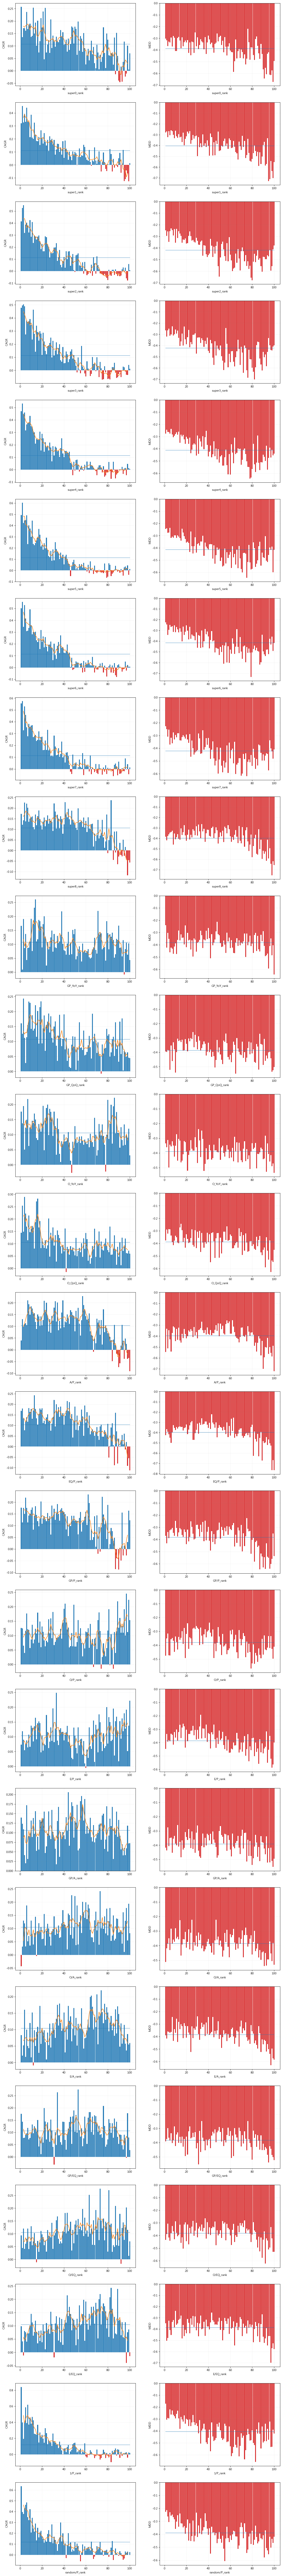

In [69]:
import matplotlib.pyplot as plt
from base import cagr, mdd
from base.time import YearMonth
from datetime import date

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)
plt.rcParams['agg.path.chunksize'] = 10000

fig, subplots = plt.subplots(len(factors), 2)
fig.set_figwidth(16), fig.set_figheight(6 * len(factors))

summary = pd.DataFrame()
for i in range(len(factors)):
    print(f"\r{i + 1}/{len(factors)}", end="")
    factor = factors[i]
    colname_rank = f"{factor}_rank"
    rank = sorted(set(result[colname_rank].dropna()))
    mean_by_rank = []
    cagr_by_rank = []
    mdd_by_rank = []
    for r in rank:
        rankers = result[result[colname_rank] == r]
        return_by_ym = rankers.groupby("매도년월")["수익률"].mean()
        begin = YearMonth.from_string(rankers["매수년월"].min())
        cumprod = (return_by_ym + 1).cumprod()
        last = cumprod[-1]
        mean_by_rank.append(return_by_ym.mean())
        cagr_by_rank.append(cagr(1, last, rankers["매도년월"].unique().size / 12))
        dates = [date(int(s.split("-")[0]), int(s.split("-")[1]), 1) for s in return_by_ym.index]
        mdd_by_rank.append(mdd(dates, cumprod.values)[0])

    ax1, ax2 = subplots[i][0], subplots[i][1]

    cagr_by_rank_series = pd.Series(cagr_by_rank)
    mdd_by_rank_series = pd.Series(mdd_by_rank)

    ax1.set_xlabel(colname_rank)
    ax1.set_ylabel("CAGR")
    ax1.grid(True)
    ax1.bar(rank, cagr_by_rank, color=["tab:blue" if v > 0 else "tab:red" for v in cagr_by_rank])
    ax1.plot(rank, [cagr_by_rank_series.mean() for _ in rank], alpha=0.5)
    ax1.plot(rank, cagr_by_rank_series.rolling(5, center=True).mean())

    ax2.set_xlabel(colname_rank)
    ax2.set_ylabel("MDD")
    ax2.grid(True)
    ax2.bar(rank, mdd_by_rank, color=["tab:blue" if v > 0 else "tab:red" for v in mdd_by_rank])
    ax2.plot(rank, [mdd_by_rank_series.mean() for _ in rank], alpha=0.5)

    corr = pd.DataFrame({colname_rank: rank, "cagr": cagr_by_rank}).corr(method="spearman")
    summary = pd.concat([
        summary,
        pd.Series({
            "spearman": corr[colname_rank]["cagr"],
            "top": cagr_by_rank_series.head(1).mean(),
            "h5": cagr_by_rank_series.head(5).mean(),
            "h10": cagr_by_rank_series.head(10).mean(),
            "t5": cagr_by_rank_series.tail(5).mean(),
            "h5-t5": cagr_by_rank_series.head(5).mean() - cagr_by_rank_series.tail(5).mean(),
            "h5-t5+mdd5": cagr_by_rank_series.head(5).mean() - cagr_by_rank_series.tail(
                5).mean() + mdd_by_rank_series.head(5).mean(),
            "mean": cagr_by_rank_series.mean(),
            "median": cagr_by_rank_series.median(),
            "mdd5": mdd_by_rank_series.head(5).mean(),
        }).to_frame(factor).T
    ])

print()
print(result["매수년월"].min(), result["매도년월"].max())
print(recipes)

summary.index.name = "factor"
summary.to_sql("sfw", sqlite3.connect(".cache/cache.db"), if_exists="replace")
summary = summary.sort_values("h5", ascending=False)
summary

In [70]:
_key = ["매수년월", "매도년월"]
benchmark = result.groupby(_key)["수익률"].mean()

factor = "super3"
print(recipes[3])
head = 20
result2 = result[~result["종목명"].str.endswith("홀딩스")]
result2 = result2[~result2["종목명"].str.endswith("지주")]
result2 = result2[result2["1/P"].rank(ascending=False, method="min", pct=True) < 0.3]

strategy = result2.groupby(_key).apply(
    lambda values: values.sort_values(factor, ascending=False).head(head)["수익률"].mean())
strategy = pd.Series(strategy, index=benchmark.index).fillna(0)
result2.groupby(_key).apply(lambda values: values.sort_values(factor, ascending=False).head(head))[
    ["code", "종목명", "수익률", "거래소", "매수일", "매도일", "매수가", "매도가", factor]]

{'GP/P': 5, '1/P': 10, 'GP_YoY': 1, 'GP_QoQ': 2, 'O_YoY': 1, 'O_QoQ': 2}


code       종목명       수익률     거래소         매수일  \
매수년월    매도년월                                                             
2015-01 2015-02 183909  073570      어반리튬  0.134756  KOSDAQ  2015-01-30   
                185269  098660      에스티오  0.258403  KOSDAQ  2015-01-30   
                183951  020400      대동금속  0.100735  KOSDAQ  2015-01-30   
                184952  046310     백금T&A  0.155209  KOSDAQ  2015-01-30   
                183730  045510     정원엔시스  0.165714  KOSDAQ  2015-01-30   
...                        ...       ...       ...     ...         ...   
2022-10 2022-11 373518  032580      피델릭스 -0.007782  KOSDAQ  2022-10-31   
                372404  084870    TBH글로벌  0.143275   KOSPI  2022-10-31   
                374041  030720      동원수산  0.029630   KOSPI  2022-10-31   
                372542  038060       루멘스  0.090476  KOSDAQ  2022-10-31   
                372088  208350  지란지교시큐리티  0.056029  KOSDAQ  2022-10-31   

                               매도일   매수가     매도가    super3  
매수년월    매도년월                                                
2015-01 2015-02 183909  2015-02-27  3703  4202.0  0.065371  
                185269  2015-02-27  1428  1797.0  0.055365  
                183951  2015-02-27  5579  6141.0  0.054624  
                184952  2015-02-27  1862  2151.0  0.044735  
                183730  2015-02-27   875  1020.0  0.042386  
...                            ...   ...     ...       ...  
2022-10 2022-11 373518  2022-11-30  1285  1275.0  0.028292  
                372404  2022-11-30  1710  1955.0  0.028231  
                374041  2022-11-30  9450  9730.0  0.027673  
                372542  2022-11-30  1050  1145.0  0.027511  
                372088  2022-11-30  4105  4335.0  0.027043  

[1880 rows x 9 columns]

In [73]:
from base import cagr, mdd
from base.time import YearMonth

revisions = pd.DataFrame({
    "벤치마크 수익률": benchmark,
    "전략 수익률": strategy,
    "성능": round(strategy - benchmark, 2),
    "벤치마크 누적수익률": (benchmark + 1).cumprod(),
    "전략 누적수익률": (strategy + 1).cumprod()
})


def str_to_ym(_s: str):
    _sp = _s.split("-")
    return YearMonth(int(_sp[0]), int(_sp[1]))


begin = str_to_ym(revisions.index[0][0])
end = str_to_ym(revisions.index[-1][-1])
years = (end.value() - begin.value()) / 12

summary = pd.DataFrame({
    "CAGR": [cagr(1, revisions["전략 누적수익률"][-1], years), cagr(1, revisions["벤치마크 누적수익률"][-1], years)],
    "MDD": [mdd([i2 for _, i2 in revisions.index], revisions["전략 누적수익률"]),
            mdd([i2 for _, i2 in revisions.index], revisions["벤치마크 누적수익률"])],
    "Mean": [revisions["전략 수익률"].mean(), revisions["벤치마크 수익률"].mean()]
}, index=["전략", "벤치마크"])
print(summary)

revisions

          CAGR                                        MDD      Mean
전략    0.471548  (-0.2375233021275095, (2018-05, 2018-10))  0.036070
벤치마크  0.119138  (-0.3031400080571939, (2021-06, 2022-09))  0.011399


,,벤치마크 수익률,전략 수익률,성능,벤치마크 누적수익률,전략 누적수익률
매수년월,매도년월,,,,,
2015-01,2015-02,0.079079,0.138328,0.06,1.079079,1.138328
2015-02,2015-03,0.076442,0.077321,0.00,1.161567,1.226345
2015-03,2015-04,0.065082,0.065149,0.00,1.237164,1.306241
2015-04,2015-05,0.032740,-0.012311,-0.05,1.277668,1.290160
2015-05,2015-06,0.040448,0.051610,0.01,1.329347,1.356745
...,...,...,...,...,...,...
2022-06,2022-07,0.064967,0.099605,0.03,2.567593,20.366185
2022-07,2022-08,0.007833,-0.003724,-0.01,2.587704,20.290331
2022-08,2022-09,-0.154665,-0.165347,-0.01,2.187477,16.935380


전체 개월 수      94.00
초과수익 개월 수    63.00
아웃퍼폼 총합       2.88
언더퍼폼 총합      -0.58
dtype: float64

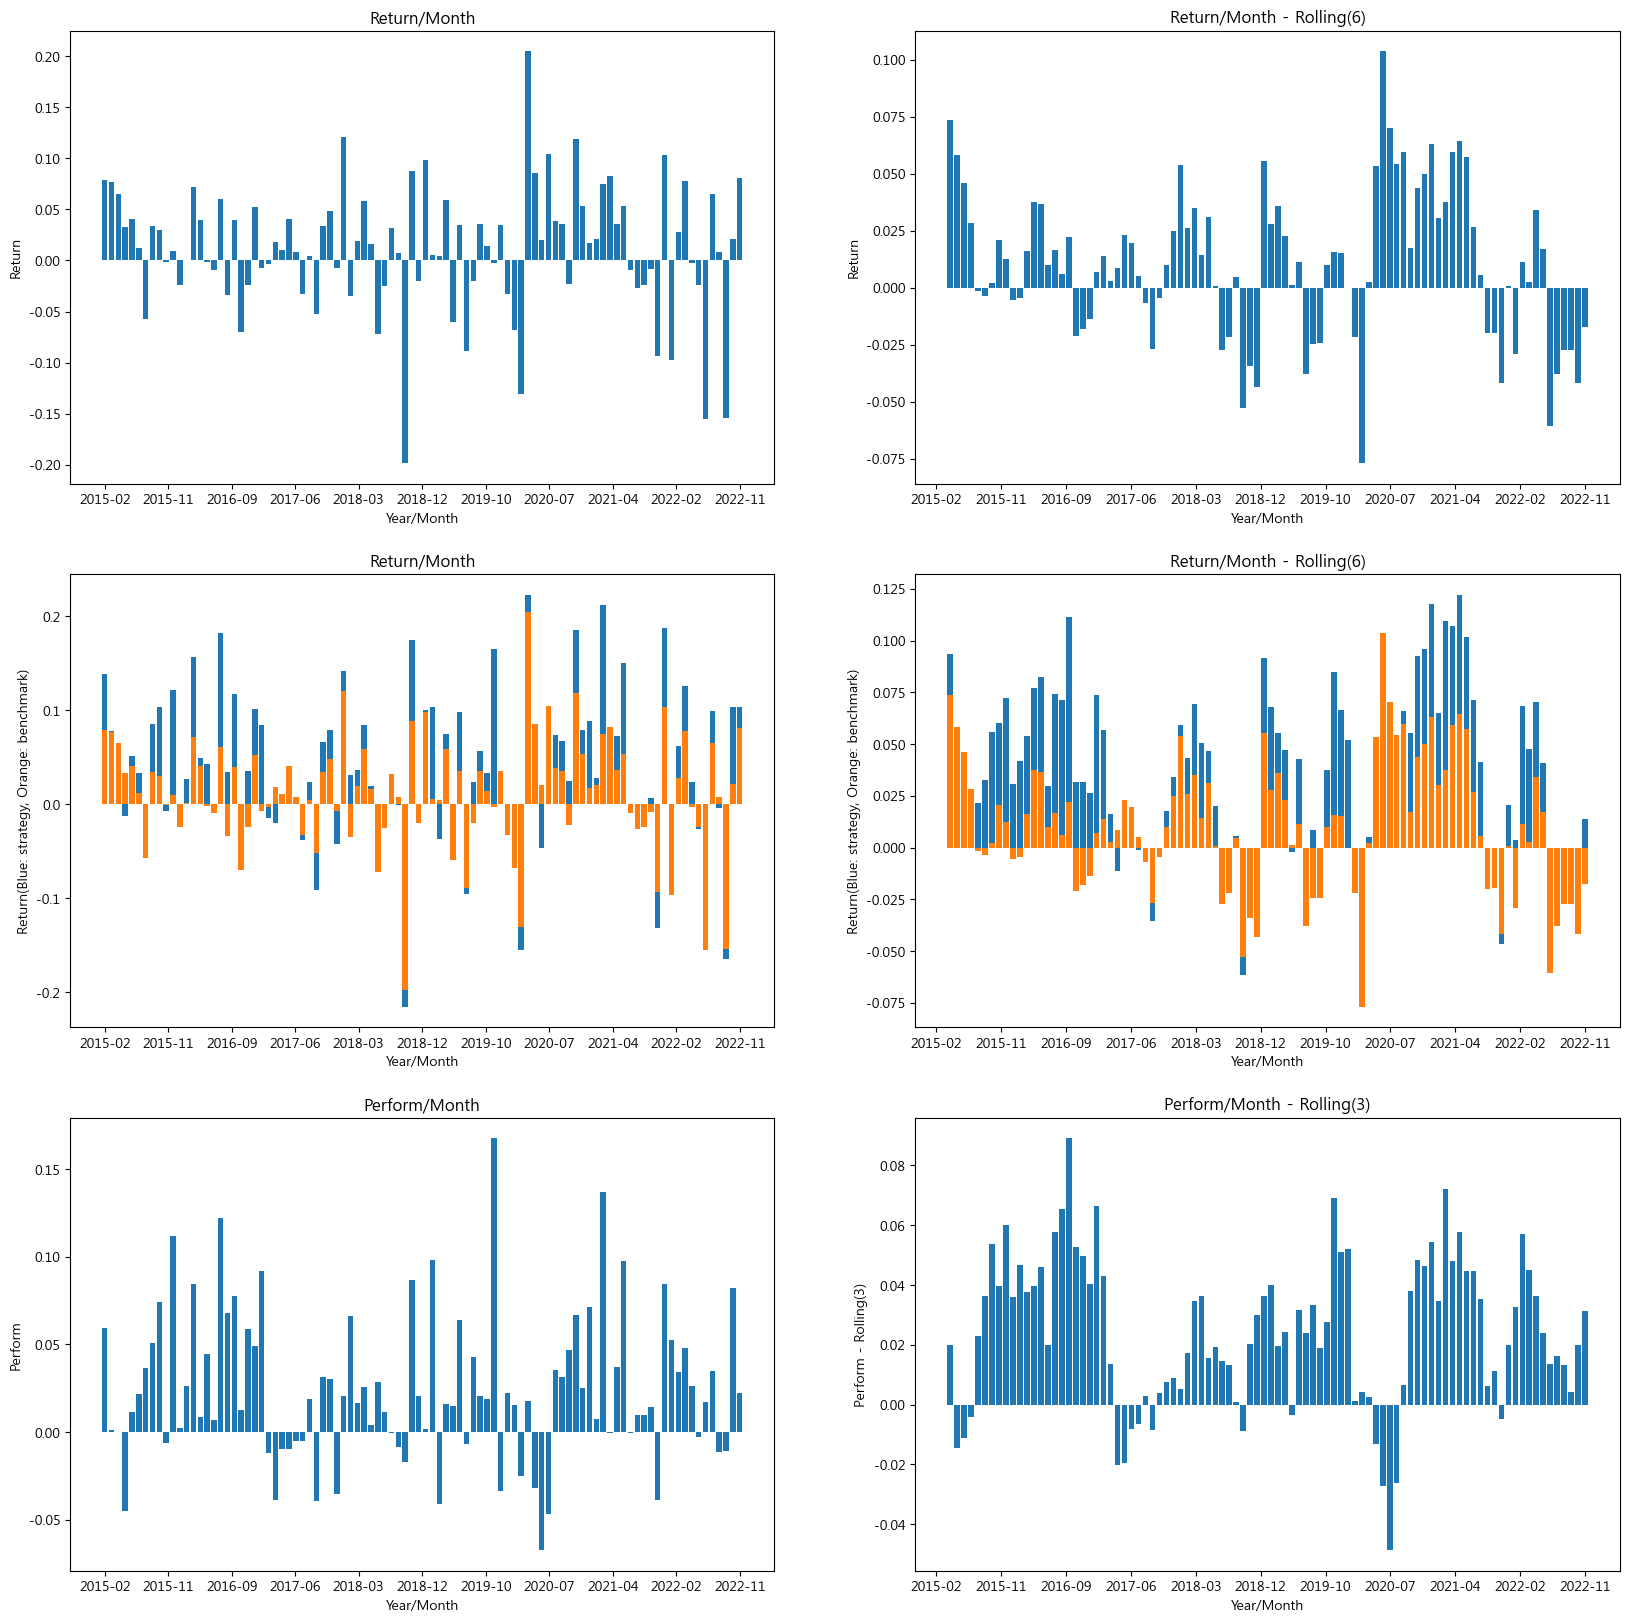

In [74]:
import numpy as np
import matplotlib.pyplot as plt

rank = [i for _, i in strategy.index]

plt.rc("font", family="Malgun Gothic")
plt.rc('axes', unicode_minus=False)
plt.rcParams['grid.color'] = (0.5, 0.5, 0.5, 0.1)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.set_figwidth(20)
fig.set_figheight(20)

xticks = [1 * i / 10 for i in range(10)] + [1]

ax1.set_title(f"Return/Month")
ax1.set_xlabel("Year/Month")
ax1.set_ylabel("Return")
ax1.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax1.bar(rank, revisions["벤치마크 수익률"])

window = 3
ax2.set_title("Return/Month - Rolling(6)")
ax2.set_xlabel("Year/Month")
ax2.set_ylabel("Return")
ax2.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax2.bar(rank, revisions["벤치마크 수익률"].rolling(window).mean())

ax3.set_title(f"Return/Month")
ax3.set_xlabel("Year/Month")
ax3.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax3.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax3.bar(rank, revisions["전략 수익률"])
ax3.bar(rank, revisions["벤치마크 수익률"])

ax4.set_title("Return/Month - Rolling(6)")
ax4.set_xlabel("Year/Month")
ax4.set_ylabel("Return(Blue: strategy, Orange: benchmark)")
ax4.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax4.bar(rank, revisions["전략 수익률"].rolling(window).mean())
ax4.bar(rank, revisions["벤치마크 수익률"].rolling(window).mean())

ax5.set_title("Perform/Month")
ax5.set_xlabel("Year/Month"), ax5.set_ylabel("Perform")
ax5.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax5.bar(rank, revisions["전략 수익률"] - revisions["벤치마크 수익률"])

ax6.set_title(f"Perform/Month - Rolling({window})")
ax6.set_xlabel("Year/Month")
ax6.set_ylabel(f"Perform - Rolling({window})")
ax6.set_xticks(np.quantile(np.arange(0, len(revisions)), xticks))
ax6.bar(rank, (revisions["전략 수익률"] - revisions["벤치마크 수익률"]).rolling(window).mean())

pd.Series({
    "전체 개월 수": len(revisions),
    "초과수익 개월 수": len(revisions[revisions["성능"] > 0]),
    "아웃퍼폼 총합": revisions[revisions["성능"] > 0]["성능"].sum(),
    "언더퍼폼 총합": revisions[revisions["성능"] < 0]["성능"].sum()
})